In [25]:
from gurobipy import *
import numpy as np

In [26]:
mod = Model()  #creating the model

In [27]:
# Putting the initial values
x_0 = 0.0
vx_0 = 15
ax_0 = 0.0
y_0 = 2.5
vy_0 = 0.0
ay_0 = 0.0
x_f = 80.0
vx_f = 12.0
y_f = 2.5
vy_f = 0.0

deltaT = 0.25 #time increment
N = 30 # number of point
print(deltaT*N) #total time

7.5


In [28]:
# Adding the variables to the model

x = mod.addVars(N, lb=0, ub=200, vtype=GRB.CONTINUOUS, name="x")
y = mod.addVars(N, lb =0, ub=5, vtype=GRB.CONTINUOUS, name="y")
vx = mod.addVars(N, lb=0, ub=20,  vtype=GRB.CONTINUOUS, name="vx")
vy = mod.addVars(N, lb=-2, ub =2, vtype=GRB.CONTINUOUS, name="vy")
ax = mod.addVars(N, lb=-4, ub=3, vtype=GRB.CONTINUOUS, name="ax")
ay = mod.addVars(N, lb=-1, ub=1, vtype=GRB.CONTINUOUS, name="ay")
jx = mod.addVars(N, lb=-5, ub=5, vtype=GRB.CONTINUOUS, name="jx")
jy = mod.addVars(N, lb=-5, ub=5, vtype=GRB.CONTINUOUS, name="jy")

# These are the binary arrays
d_1 = mod.addVars(N, name = 'd_1', vtype = GRB.BINARY) 
d_2 = mod.addVars(N, name = 'd_2', vtype = GRB.BINARY)
d_3 = mod.addVars(N, name = 'd_3', vtype = GRB.BINARY)



In [29]:
# Creating the cost function, it is simplified, we don't consider y since it is constant

cost = LinExpr()
for i in range (N):
    if i == 0:
        cost+= 100*(x[N-1]-x_f)**2
    cost += 4*ax[i]**2 + 10*jx[i]**2 + (vx[i]-12)**2 
mod.setObjective( cost , GRB.MINIMIZE)

In [30]:
# initial constraints
mod.addConstr(x[0] == x_0,  name="initx")
mod.addConstr(y[0] == y_0,  name="inity")
mod.addConstr(vx[0] == vx_0, name="initvx")

# velocity, acceleration and position constraints
mod.addConstrs((x[i] + deltaT*vx[i] + 0.5*(deltaT**2)*ax[i] + (1/6)*(deltaT**3)*jx[i] == x[i+1] for i in range(N-1)),"c1")
mod.addConstrs((y[i] + deltaT*vy[i] + 0.5*(deltaT**2)*ay[i] + (1/6)*(deltaT**3)*jy[i] == y[i+1] for i in range(N-1)),"c2")
mod.addConstrs((vx[i] + deltaT*ax[i] + 0.5*(deltaT**2)*jx[i]  == vx[i+1] for i in range(N-1)),"c3")
mod.addConstrs((vy[i] + deltaT*ay[i] + 0.5*(deltaT**2)*jy[i] == vy[i+1] for i in range(N-1)),"c4")
mod.addConstrs((ax[i] + deltaT*jx[i] == ax[i+1] for i in range(N-1)),"j3")
mod.addConstrs((ay[i] + deltaT*jy[i] == ay[i+1] for i in range(N-1)),"j4")

M=100
mod.addConstrs((x[i] >= 29+0.001 - M*(1-d_1[i]) for i in range(N)), "c5")
mod.addConstrs((x[i] <= 29 + M*d_1[i] for i in range(N)), "c6")
mod.addConstrs((x[i] >= 51 - M*d_2[i] for i in range(N)), "c7")
mod.addConstrs((x[i] <= 51 + M*(1-d_2[i]) for i in range(N)), "c8")
mod.addConstrs((vx[i] >= 10 - M*d_3[i] for i in range(N)), "c9")
mod.addConstrs((vx[i] <= 10 + M*(1-d_3[i]) for i in range(N)), "c10")

mod.addConstrs((-d_1[i] + d_3[i] <= 0 for i in range(N)), "c11")
mod.addConstrs((-d_2[i] + d_3[i] <= 0 for i in range(N)), "c12")
mod.addConstrs((d_1[i] + d_2[i] - d_3[i] <= 1 for i in range(N)), "c13")# 


mod.addConstrs((y[i] == 2.5 for i in range(N)), "y_same")




print(" ")





In [31]:
mod.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: AMD Ryzen 5 5600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 477 rows, 330 columns and 1299 nonzeros
Model fingerprint: 0xf5acd20b
Model has 91 quadratic objective terms
Variable types: 240 continuous, 90 integer (90 binary)
Coefficient statistics:
  Matrix range     [3e-03, 1e+02]
  Objective range  [2e+01, 2e+04]
  QObjective range [2e+00, 2e+02]
  Bounds range     [1e+00, 2e+02]
  RHS range        [1e+00, 2e+02]
Presolve removed 338 rows and 206 columns
Presolve time: 0.01s
Presolved: 139 rows, 124 columns, 461 nonzeros
Presolved model has 89 quadratic objective terms
Variable types: 109 continuous, 15 integer (15 binary)
Found heuristic solution: objective 481.5522852

Root relaxation: objective 3.521667e+02, 148 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objectiv

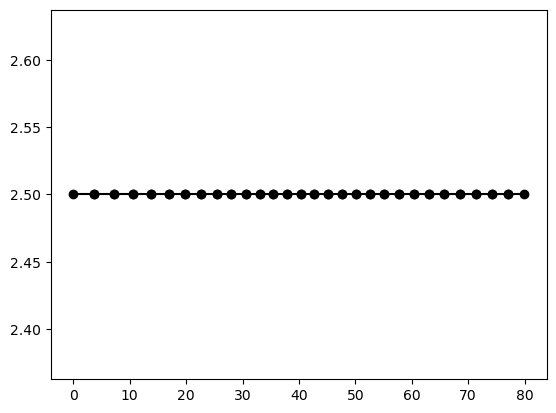

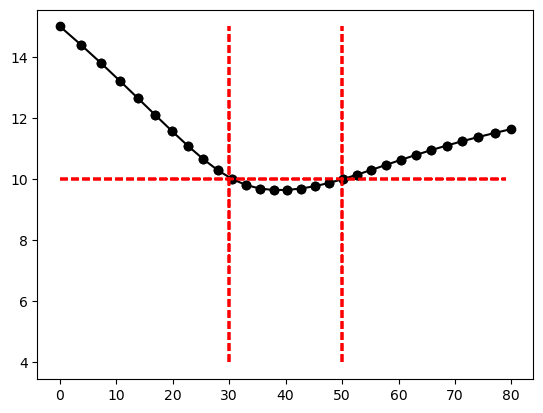

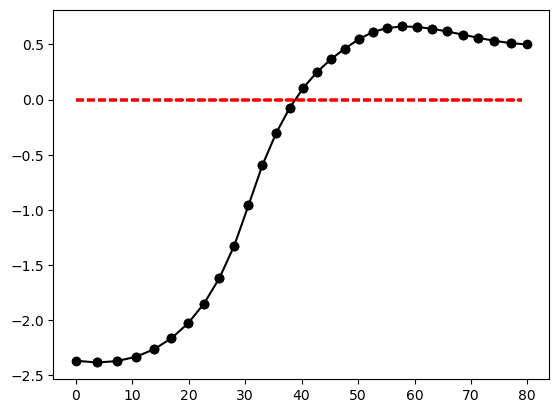

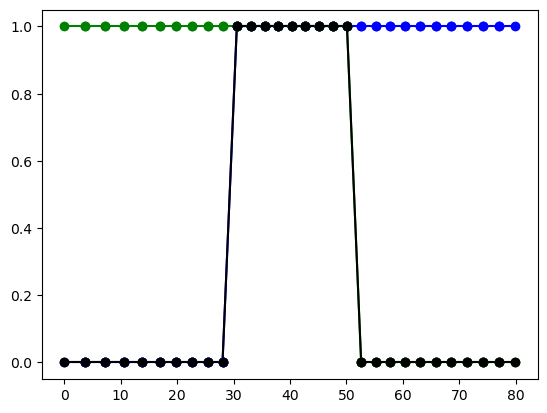

In [32]:
import matplotlib.pyplot as plt

if mod.Status == GRB.OPTIMAL:
  arr = np.ones(80)*10
  x_arr = np.arange(80)
  ver_arr_x = np.ones(12)*30
  ver_arr_x2 = np.ones(12)*50
  ver_arr_y = np.arange(4,16)
  for i in range(N-1):
    plt.figure(1)
    plt.plot([x[i].X, x[i+1].X],[y[i].X, y[i+1].X], 'ko-')

    plt.figure(2)
    plt.plot([x[i].X, x[i+1].X],[vx[i].X, vx[i+1].X], 'ko-')
    plt.plot(x_arr, arr, 'r--')
    plt.plot(ver_arr_x, ver_arr_y, 'r--')
    plt.plot(ver_arr_x2, ver_arr_y, 'r--')

    plt.figure(3)
    plt.plot([x[i].X, x[i+1].X],[ax[i].X, ax[i+1].X], 'ko-')
    acc_zero = np.zeros(80)
    plt.plot(x_arr, acc_zero, 'r--' )

    plt.figure(4)
    plt.plot([x[i].X, x[i+1].X],[d_1[i].X, d_1[i+1].X], 'bo-')
    plt.plot([x[i].X, x[i+1].X],[d_2[i].X, d_2[i+1].X], 'go-')
    plt.plot([x[i].X, x[i+1].X],[d_3[i].X, d_3[i+1].X], 'ko-')



  plt.show()